In [86]:


%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import librosa
import librosa.display

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchaudio
print(torch.__version__)
print(torchaudio.__version__)

from src import load_music as load

plt.rcParams['figure.figsize'] = (17, 5)


1.10.1+cu113
0.10.1+cu113


In [2]:
AUDIO_DIR = './fma/fma_small/fma_small'

In [3]:
filename = load.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: ./fma/fma_small/fma_small/000/000002.mp3


/home/sga/data/mir/venv/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


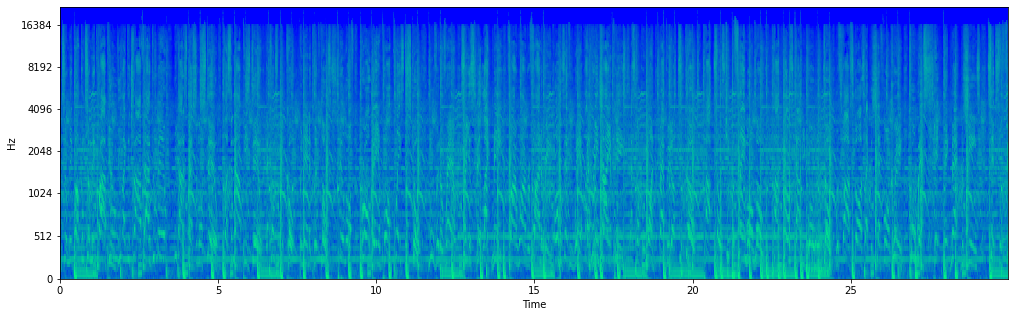

In [4]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel, top_db=None)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap="winter");

In [5]:
# From https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin='lower', aspect=aspect, cmap="winter")
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

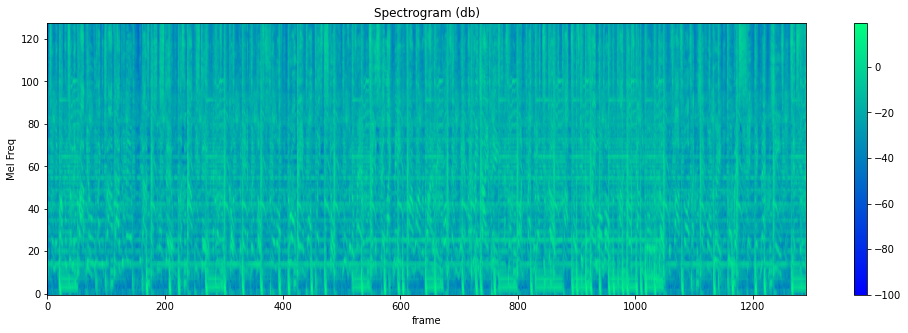

In [85]:
# Now we use torch for the same stuff and compare the output using Torch for the same
song_wave, song_sr = torchaudio.load(filename)
melspec_t = torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_fft=2048, f_max=10000, normalized=True)
amp_to_int = torchaudio.transforms.AmplitudeToDB()
song_spec = amp_to_int(melspec_t(song_wave))
plot_spectrogram(song_spec[0], ylabel="Mel Freq")

A note about this spectrogram: We are using 128 Mel-bins and 2048 fft bins for the sft. This gives us a pretty good resolution on the freq side, the hop length is n_fft//2 by default, which should also be a decent time index. We can change it to `n_fft//4` for better resolution.
We discard any frequencies above 10 kHz, they have little impact on perception it seems.

We are not going for MFCC, this is good enough for us. The x axis has time and the y-axis is the mel frequency, scaled not by amplitude but by intensity. That's good enough for a CNN to start work on.
So, the melspecs from librosa and torch are equivalent, more or less.

In [17]:
tracks = load.load_meta('./fma/fma_metadata/fma_metadata/tracks.csv')
tracks.shape

(106574, 52)

In [70]:
small = tracks['set', 'subset'] <= 'small'
blacklist = [98565, 98567, 98569, 99134, 108925, 133297]
small[blacklist] = False
train = tracks.index[small & (tracks['set', 'split'] == 'training')]
val = tracks.index[small & (tracks['set', 'split'] == 'validation')]
test = tracks.index[small & (tracks['set', 'split'] == 'test')]

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top'][small]).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))

6394 training examples, 800 validation examples, 800 testing examples
Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [65]:
tracks['track', 'genre_top'].loc[train[0]]

'Hip-Hop'

__Now__ we go make the dataloader:

In [81]:
class FmaLoader(Dataset):
    """
    :param split: must be either "training", "validation" or "test"; anything else and you get an empty dataset
    :param subset: "small" by default
    """
    def __init__(self, audio_root, tracks_file, split, blacklist = [98565, 98567, 98569, 99134, 108925, 133297], subset="small"):
        self.tracks = load.load_meta(tracks_file)
        self.audio_root = audio_root
        self.subset = self.tracks['set','subset'] <= subset
        self.subset[blacklist] = False
        self.split = self.tracks['set', 'split'] == split
        self.rows = tracks.index[self.subset & self.split]
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, item):
        label = self.tracks['track', 'genre_top'].loc[self.rows[item]]
        # We ignore the sample rate of the song, the model can choose that for itself
        waveform, _ = torchaudio.load(load.get_audio_path(self.audio_root, train[item]), num_frames=44100*29)
        return waveform, genres.index(label)

Feature batch shape: torch.Size([32, 2, 1278900])
Labels batch shape: torch.Size([32])


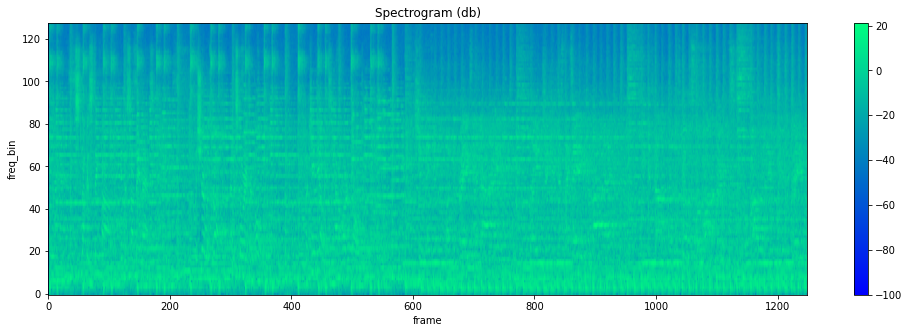

In [82]:
train_dataloader = DataLoader(dataset=FmaLoader(audio_root=AUDIO_DIR, tracks_file="./fma/fma_metadata/fma_metadata/tracks.csv", split="training"), batch_size=32, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
train_wv = train_features[0].squeeze()
train_lbl = train_labels[0]
plot_spectrogram(amp_to_int(melspec_t(train_wv[0])))

It seems that not every waveform has the same number of frames due to the different sampling rates, even though the time duration is the same. It works, though!
**BUT, the shape of the feature batch suggests that we still have stereo audio, we need to reduce it to mono!**0

Now, to make the model and train it!

In [ ]:
class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=(4,1), padding=(0,2), pooling=(4,1), dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=padding)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)

    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

In [ ]:
class Gramophone(nn.Module):
    def __init__(self):
        super(Gramophone, self).__init__()

        # Process into spectrogram here

        self.c1 = Conv_2d()